## To Do
- Prevent/improve handling of duplicates

In [1]:
from pathlib import Path
import gc

import numpy as np
import pandas as pd
import geopandas as gpd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import GroupShuffleSplit, GroupKFold #train_test_split, RepeatedKFold
from sklearn.linear_model import Ridge #, RidgeCV
#from sklearn.ensemble import RandomForestRegressor

from custom.preprocessing import add_shrug_to_mosaiks, latlon_df_to_gdf
from custom.shrug_data import (
    load_shrug_shapefiles,
    load_and_combine_shrug_data,
    aggregate_shrug_to_block
)
from custom.evaluation import show_results, plot_prediction_maps, get_cutoff_range_metrics, plot_metrics

In [2]:
ROOT = Path.cwd().parent
DATA_ROOT = ROOT / "data"

## Load and merge data

### Mosaiks features (with Lat-Lon Coords)

API data

In [3]:
# filename = 'api_urb_rur_request_points.csv'
# data_label = "api_v4000"

# # Load data
# mosaiks_features = pd.read_csv(DATA_ROOT / "01_preprocessed/mosaiks_features" / filename)
# print("No. points:", mosaiks_features.shape[0])
# # rename columns to match in-house data
# mosaiks_features.columns = ["Lat", "Lon"] + [str(i) for i in range(4000)]
# # convert to gpd
# mosaiks_features_gdf = latlon_df_to_gdf(mosaiks_features)

2016 Sentinel

In [4]:
filename = '2016_exact_2400m_v4000_S2_0_to_99896.parquet.gzip'
data_label = "2016_S2_2400m_v4000"

# Load data
mosaiks_features = pd.read_parquet(DATA_ROOT / "01_preprocessed/mosaiks_features" / filename)
mosaiks_features_gdf = latlon_df_to_gdf(mosaiks_features)
print("No. points:", mosaiks_features_gdf.shape[0])

mosaiks_features_gdf = mosaiks_features_gdf.dropna()
print("No. points after dropping NAs:", mosaiks_features_gdf.shape[0])

# Note: Due to an .sjoin in the mosaiks_points.py script, there are some duplicates here - now fixed. New coordinates must be generated and requested.
filter = mosaiks_features_gdf.duplicated(subset=["Lat","Lon"], keep="first")
mosaiks_features_gdf = mosaiks_features_gdf[~filter]

No. points: 99897
No. points after dropping NAs: 67740


2013 Landsat

In [5]:
# filename = '2013_exact_2400m_v4000_L8_0_to_96166.parquet.gzip'
# data_label = "2013_2400m_v4000"

# # Load data
# mosaiks_features = pd.read_parquet(DATA_ROOT / "01_preprocessed/mosaiks_features" / filename)
# mosaiks_features_gdf = latlon_df_to_gdf(mosaiks_features)
# print("No. points:", mosaiks_features_gdf.shape[0])

# mosaiks_features_gdf = mosaiks_features_gdf.dropna()
# print("No. points after dropping NAs:", mosaiks_features_gdf.shape[0])

# # Note: Due to an .sjoin in the mosaiks_points.py script, there are some duplicates here - now fixed. New coordinates must be generated and requested.
# filter = mosaiks_features_gdf.duplicated(subset=["Lat","Lon"], keep="first")
# mosaiks_features_gdf = mosaiks_features_gdf[~filter]

2021 data

In [6]:
# # data_label_21 = "2021_2400km_v4000"
# filename_21 = '2021_exact_2400m_v4000_L8_0_to_96166.parquet.gzip'

# # Load data
# mosaiks_features_21 = pd.read_parquet(DATA_ROOT / "01_preprocessed/mosaiks_features" / filename_21)
# mosaiks_features_gdf_21 = latlon_df_to_gdf(mosaiks_features_21)
# print("No. points:", mosaiks_features_gdf_21.shape[0])

# mosaiks_features_gdf_21 = mosaiks_features_gdf_21.dropna()
# print("No. points after dropping NAs:", mosaiks_features_gdf_21.shape[0])

# # TEMPORARY FIX for duplicate rows. Remove when corrected new data is generated.
# filter = mosaiks_features_gdf_21.duplicated(subset=["Lat","Lon"], keep="first")
# mosaiks_features_gdf_21 = mosaiks_features_gdf_21[~filter]

### SHRUG data (geometries + populations + SECC)

Town/village-level rates (SHRID-level)

In [8]:
# if never run before:
# shrug_pop_secc_gdf = load_and_combine_shrug_data()

# else load from file:
shrug_pop_secc_gdf = gpd.read_parquet(DATA_ROOT / "01_preprocessed/SHRUG/combined/shrug_pop_secc.parquet.gzip")

Number of SHRIDs with both urban and rural poverty rate: 125


Block-level rates (Group SHRUG Villages/Towns)

In [9]:
#shrug_block_pop_secc_gdf = aggregate_shrug_to_block(shrug_pop_secc_gdf)

### Merge Mosaiks featues and SECC target via shapes

Village/town-level

In [10]:
mosaiks_shrug_vt_gdf = add_shrug_to_mosaiks(mosaiks_features_gdf, shrug_pop_secc_gdf)

Block-level

In [11]:
# mosaiks_shrug_block_gdf = add_shrug_to_mosaiks(mosaiks_features_gdf, shrug_block_pop_secc)

In [12]:
del mosaiks_features
del mosaiks_features_gdf
gc.collect()

0

## Select data for modelling

Choose data to use for modelling

In [13]:
# Select dataset and target
gdf = mosaiks_shrug_vt_gdf  #mosaiks_shrug_block_gdf
y_name = "secc_pov_rate_combined" #"secc_pov_rate_subdistrict_combined"
experiment_name = data_label + "_" + y_name

In [14]:
# drop rows with unavailable target
gdf_clean = gdf.dropna(subset=y_name)
# drop rows with duplicated indices
filter = gdf_clean.index.duplicated(keep='first')
print("Rows with duplicated indices:", filter.sum())
gdf_clean = gdf_clean[~filter]

Rows with duplicated indices: 0


In [15]:
# select features and target
NUM_FEATURES = 4000
mosaiks_column_names = [str(i) for i in range(NUM_FEATURES)]

X = gdf_clean[mosaiks_column_names]
y = gdf_clean[y_name]

Grouped train-test split: making sure that datapoints from the same village don't get split across train and test datasets (to avoid leakage).

Can change grouping variable to larger scale if needed (e.g. unique subdistrict IDs, etc)

In [16]:
# choose train/test indices
grouping_var = "pc11_tv_id" #"pc11_sd_id"
splitter = GroupShuffleSplit(test_size=0.30, n_splits=1, random_state=0)
split = splitter.split(gdf_clean, groups=gdf_clean[grouping_var])
train_index_position, test_index_position = list(split)[0]

# convert to true pandas indices
train_index = gdf_clean.index[train_index_position]
test_index = gdf_clean.index[test_index_position]

[In-house data only] If 2021 data available, make sure all rows selected in the test data are also available in 2021

In [17]:
# # only keep test indices that also appear in the 2021 data (for comparison later)
# print("No. test points 2013:", len(test_index))
# test_index = np.intersect1d(test_index, mosaiks_features_gdf_21.index)
# print("Common test points:", len(test_index))

# # select 2021 test data
# X_test_21 = mosaiks_features_gdf_21.loc[test_index].drop(["Lat", "Lon", "geometry"], axis=1)

In [18]:
# split data into train and test
X_train, X_test, y_train, y_test = (
    X.loc[train_index],
    X.loc[test_index],
    y.loc[train_index],
    y.loc[test_index],
)

## Modelling
Datapoints = latlong points

### Train model

In [19]:
model = Ridge()
model.fit(X_train, y_train) #, sample_weight=y_train

Ridge()

- target distribution
- optimise model

In [20]:
# # or with parameter search (grouped k-fold)

# group_kfold = GroupKFold(n_splits=5)
# cv_grouped = group_kfold.split(X, y, gdf_clean[grouping_var])

# model = RidgeCV(alphas=[0.01, 1, 10], cv=cv_grouped)
# model.fit(X_train, y_train, sample_weight=y_train)

# # summarize chosen configuration
# print('alpha: %f' % model.alpha_)

### Test

Next, we use the trained model to make predictions in the test set.

In [21]:
y_pred = model.predict(X_test)

In [22]:
y_pred_21 = np.zeros(len(X_test)) #model.predict(X_test_21)

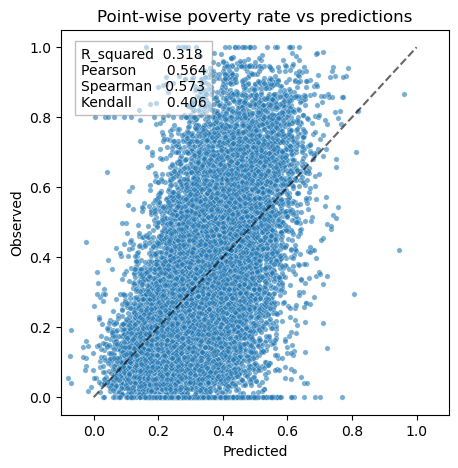

In [23]:
show_results(y_test, y_pred, file_name="scatter_"+experiment_name, title="Point-wise poverty rate vs predictions")

In [25]:
show_results(y_pred_21, y_pred, ylabel="Predicted 2021", file_name="2021_vs_13_scatter_"+experiment_name, title="Point-wise 2021 vs 2011 Poverty Rate Predictions")

Maps

In [26]:
geo_cols = [
    "Lat", "Lon",
    "shrid",
    "pc11_s_id",
    "pc11_d_id",
    "pc11_sd_id",
    "pc11_tv_id",
    "tv_name",
    "geometry",
    "geometry_village_town"
    # "geometry_subdistrict",
]

In [27]:
# select dataframe with only test target and location data
gdf_clean_test_y = gdf_clean.loc[test_index][geo_cols + [y_name]]

# add predicted values
gdf_clean_test_y.loc[:, "predicted"] = y_pred
gdf_clean_test_y.loc[:, "predicted_21"] = y_pred_21

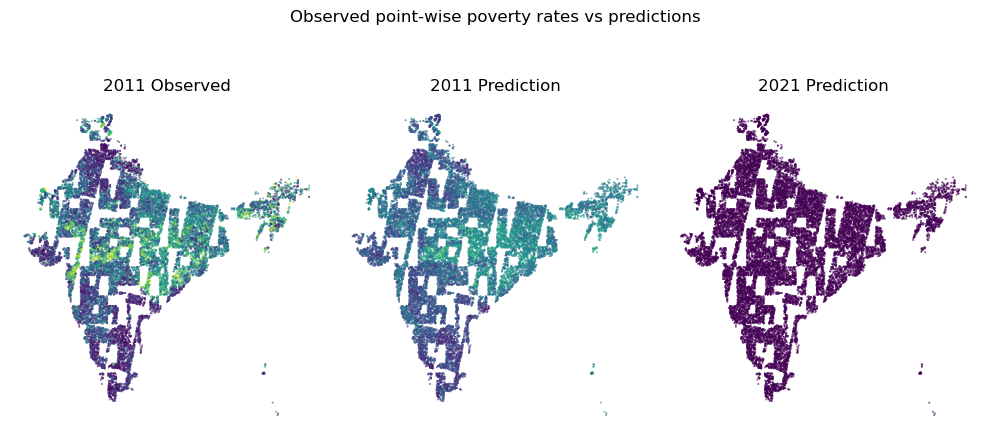

In [28]:
plot_prediction_maps(
    gdf=gdf_clean_test_y,
    y_name=y_name,
    y_pred_name="predicted",
    y_pred_2_name="predicted_21",
    vmin=0,
    vmax=1,
    file_name="2021_vs_11_maps_points_"+experiment_name,
    title="Observed point-wise poverty rates vs predictions",
    )

## Aggregate results to `Subdistricts`

In [29]:
print("Total test datapoints: ", gdf_clean_test_y.shape[0])

Total test datapoints:  18403


In [30]:
sd_shapes = load_shrug_shapefiles(level="subdistrict")
sd_shapes.drop(['pc11_s_id', 'pc11_d_id', 'pc11_sd_id'], axis=1, inplace=True)
sd_shapes["geometry_subdistrict"] = sd_shapes["geometry"]

In [31]:
gdf_clean_test_y_subdistricts = gdf_clean_test_y.sjoin(sd_shapes)

# change default geometry to subdistricts (for plotting)
gdf_clean_test_y_subdistricts["geometry_point"] = gdf_clean_test_y_subdistricts["geometry"]
gdf_clean_test_y_subdistricts["geometry"] = gdf_clean_test_y_subdistricts["geometry_subdistrict"]

In [32]:
subdistrict_ys = gdf_clean_test_y_subdistricts.groupby(
    ["pc11_s_id", "pc11_d_id", "pc11_sd_id"], 
    as_index=False,
).agg(
    {
        y_name: "mean", 
        "predicted": "mean", 
        "predicted_21": "mean", 
        "geometry": "first"
        }
)
subdistrict_ys = gpd.GeoDataFrame(subdistrict_ys)

In [33]:
print("Datapoints with unique subdistricts: ", subdistrict_ys.shape[0])

Datapoints with unique subdistricts:  3853


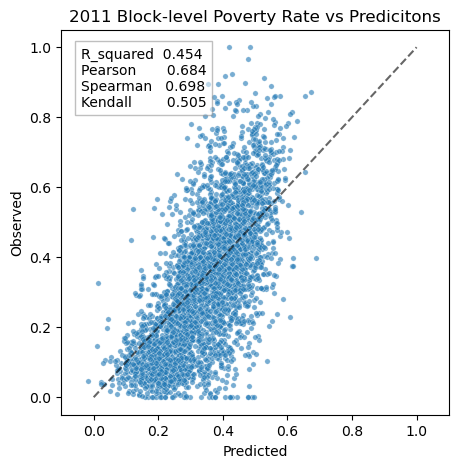

In [34]:
show_results(subdistrict_ys[y_name], subdistrict_ys["predicted"], file_name="scatter_subdistricts_"+experiment_name, title="2011 Block-level Poverty Rate vs Predicitons")

In [35]:
# show_results(subdistrict_ys["predicted_21"], subdistrict_ys["predicted"], xlabel="Predicted 2011", ylabel="Predicted 2021", file_name="2021_vs_11_scatter_subdistricts_"+experiment_name, title="2021 vs 2011 Block-level Poverty Rate Predicitons")

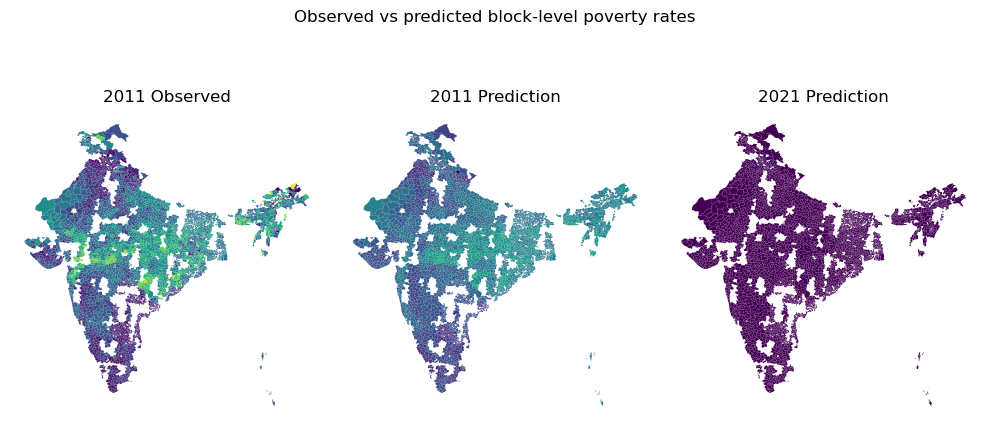

In [36]:
plot_prediction_maps(
    gdf=subdistrict_ys,
    y_name=y_name,
    y_pred_name="predicted",
    y_pred_2_name="predicted_21",
    vmin=0,
    vmax=1,
    file_name="2021_vs_11_maps_subdistricts_"+experiment_name,
    title="Observed vs predicted block-level poverty rates",
    )

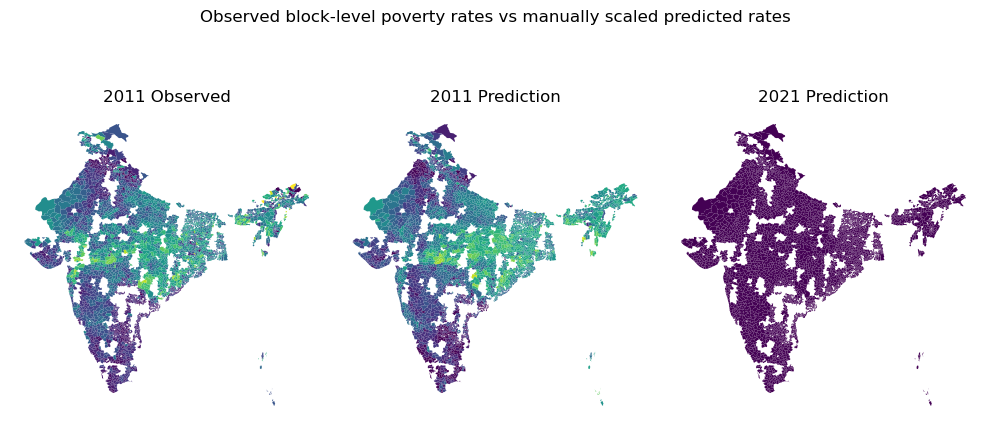

In [37]:
min, max = 0.15, 0.7
subdistrict_ys["predicted_scaled"] = ((subdistrict_ys["predicted"] - min) / (max - min))
subdistrict_ys["predicted_21_scaled"] = ((subdistrict_ys["predicted_21"] - min) / (max - min))

plot_prediction_maps(
    gdf=subdistrict_ys,
    y_name=y_name,
    y_pred_name="predicted_scaled",
    y_pred_2_name="predicted_21_scaled",
    vmin=0,
    vmax=1,
    file_name="scaled_2021_vs_13_maps_subdistricts_"+experiment_name,
    title="Observed block-level poverty rates vs manually scaled predicted rates",
    )

### Precision-Recall Curve


In [38]:
results = get_cutoff_range_metrics(y_test=subdistrict_ys[y_name], y_pred=subdistrict_ys["predicted"])

In [39]:
results.iloc[range(0, 101, 10)].round(2)

,cutoff,ground_pos,pred_pos,TP,FP,TN,FN,recall,precision
0.0,0.0,3825,3852,3824,28,0,1,1.00,0.99
0.1,0.1,3331,3808,3314,494,28,17,0.99,0.87
0.2,0.2,2701,3404,2639,765,387,62,0.98,0.78
0.3,0.3,2109,2475,1913,562,1182,196,0.91,0.77
0.4,0.4,1377,1319,883,436,2040,494,0.64,0.67
0.5,0.5,778,317,203,114,2961,575,0.26,0.64
0.6,0.6,352,18,10,8,3493,342,0.03,0.56
0.7,0.7,136,0,0,0,3717,136,0.00,0.00
0.8,0.8,43,0,0,0,3810,43,0.00,0.00
0.9,0.9,6,0,0,0,3847,6,0.00,0.00


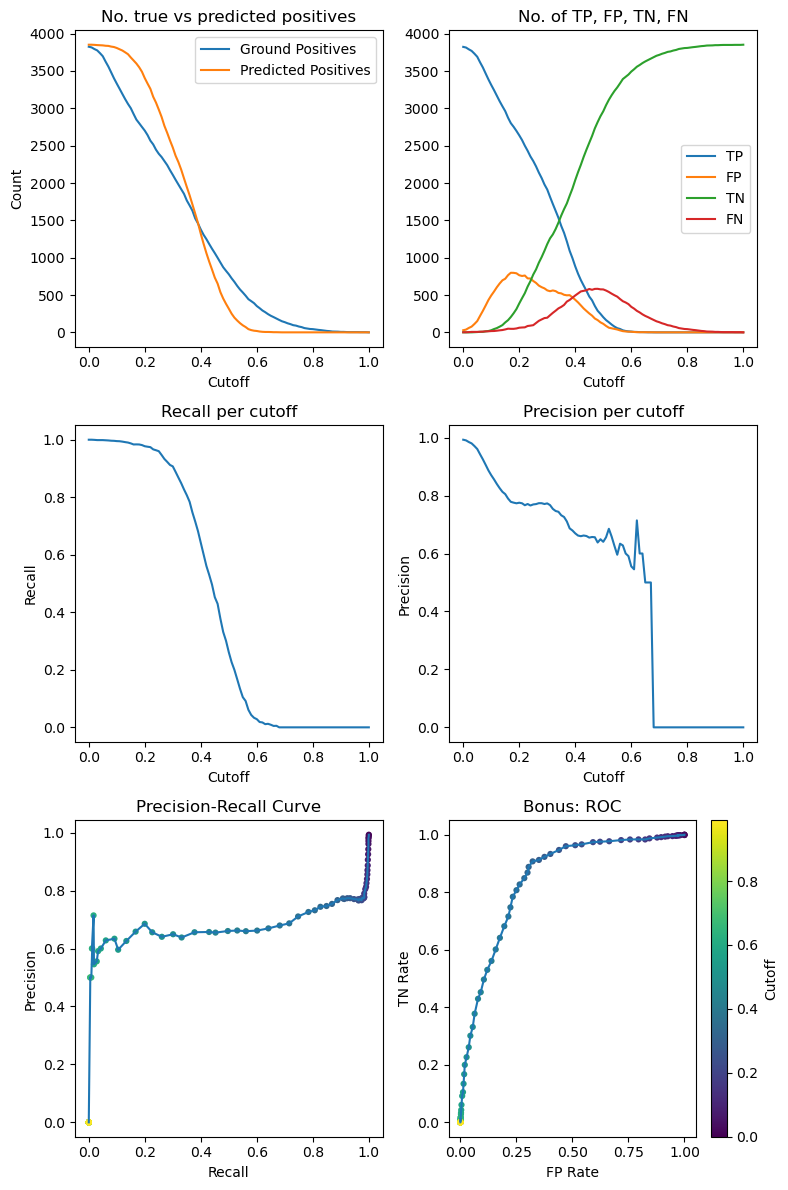

In [40]:
plot_metrics(results=results, experiment_name=experiment_name)

### Prediction performance in the poorest quintile subdistricts

In [41]:
top_quintile_cutoff = np.percentile(gdf_clean_test_y_subdistricts[y_name], [80])[0]
subdistrict_ys_top_quintile = subdistrict_ys[subdistrict_ys[y_name] > top_quintile_cutoff]
fig_name = "poorest_quintile_subdistrict"

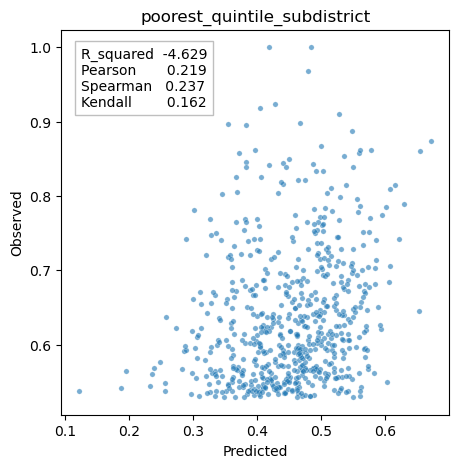

In [42]:
show_results(
    subdistrict_ys_top_quintile[y_name], 
    subdistrict_ys_top_quintile["predicted"], 
    file_name="scatter_subdistricts_"+fig_name, 
    title=fig_name, 
    line=False,
)

### Poorest quintile predictions vs poorest quintile truth

In [46]:
gdf_clean_test_y_subdistricts[y_name+"top_20_perc"] = (pd.qcut(gdf_clean_test_y_subdistricts[y_name], q=5, labels=False) == 4) * 1
gdf_clean_test_y_subdistricts["predicted_top_20_perc"] = (pd.qcut(gdf_clean_test_y_subdistricts["predicted"], q=5, labels=False) == 4) * 1
# gdf_clean_test_y_subdistricts["predicted_21_top_20_perc"] = (pd.qcut(gdf_clean_test_y_subdistricts["predicted_21"], q=5, labels=False) == 4) * 1

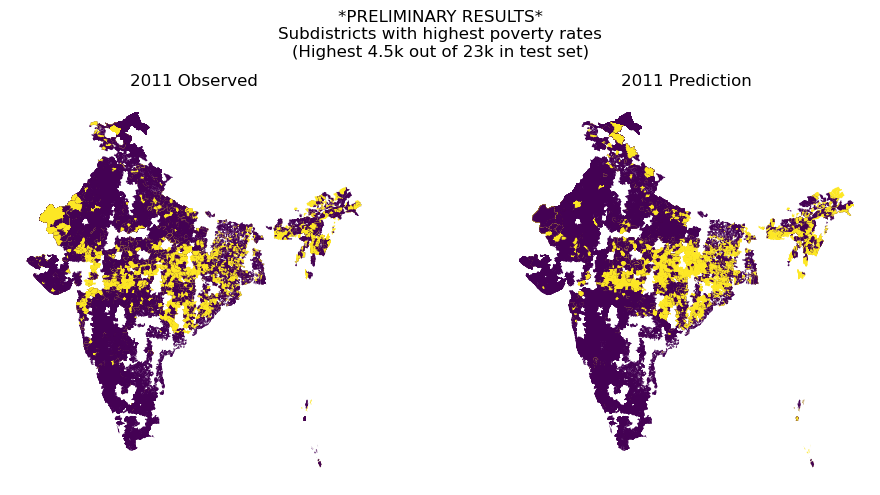

In [48]:
plot_prediction_maps(
    gdf=gdf_clean_test_y_subdistricts,
    y_name=y_name+"top_20_perc",
    y_pred_name="predicted_top_20_perc",
    y_pred_2_name=None, #"predicted_21_top_20_perc",
    vmin=0,
    vmax=1,
    file_name="2021_vs_11_maps_sd_top20_"+experiment_name,
    title="*PRELIMINARY RESULTS*\nSubdistricts with highest poverty rates\n(Highest 4.5k out of 23k in test set)",
    )

In [53]:
# pred_top_quintile = np.percentile(y_pred, [80])[0]
# y_pred_is_top_quintile = list(y_pred > pred_top_quintile)
# y_pred_is_top_quintile = gdf_clean_test_y_subdistricts["predicted_top_20_perc"]

# pred_21_top_quintile = np.percentile(y_pred_21, [80])[0]
# y_pred_21_is_top_quintile = list(y_pred_21 > pred_top_quintile)

# test_top_quintile = np.percentile(y_test, [80])[0]
# y_test_is_top_quintile = list(y_test > test_top_quintile)